In [1]:
""" This is the CovidWeb module.As the name shows, after the user have set up the environment,
they could run this module to interact and browse the Covid and unemployment data on the map.
The map will be displayed on a web page automatically. The user therefore should have a browser.

This module includes a class called CovidWeb which is inherited from "param.Parameterized".

We mainly use "panel" library to realize the widgets and the dashboard.Panel supports using 
parameters and dependencies between parameters as expressed by "param" in a simple way to 
encapsulate dashboards as declarative, self-contained classes.

Users don't need to input anything on the web page, just choose the period and the county name,
all the information or data will be loaded automatically.
"""

import pandas as pd
import panel as pn
import folium
import json
import param
import os
import webbrowser
import ToolBox

pn.extension() 

Row
    [0] Column(margin=5, name='Group-12 Map Viewer', width=300)
        [0] StaticText(value='<b>Group-12 M...)
        [1] Select(name='Months', options=OrderedDict([('March', ...]), value='March')
        [2] Select(name='Counties', options=OrderedDict([('Adams', ...]), value='Clark')
    [1] ParamMethod(method)
    [2] ParamMethod(method)

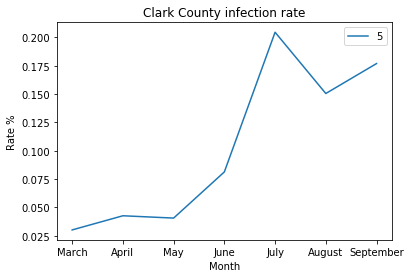

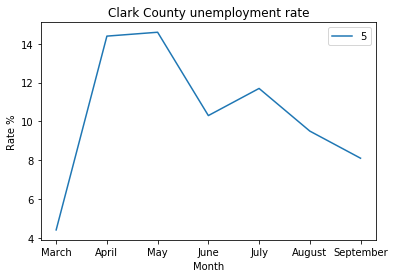

In [7]:


class CovidWeb(param.Parameterized):
    """This is the CovidWeb class which is inherited from param.Parameterized. 
    The fields include:
    Months, which is supposed to provide the users a period of time to choose when they click the button, 
    Counties, which is suppoesed to provide the users a whole list of counties of Washington State to choose
    when they click the button.
    The methods include:
    unemploy_text(self): search and return the unemployment data by implementing "ToolBox.unemploy_text_parser(county,month)"
    getGeoAndData(self): search and return the covid data, this method will be implemented in the "popup(self)"
    popup(self): build a map and add layers to it, the layers will include the covid and the unemployment data
    view(self): build the dashboard and present it as a HTML file
    """
    Months = param.ObjectSelector(default='March', objects = ['March','April','May','June','July','August','September'])
    Counties = param.ObjectSelector(default='Clark',objects = ["Adams","Asotin","Benton","Chelan","Clallam","Clark","Columbia",
                                           "Cowlitz","Douglas","Ferry","Franklin","Garfield","Grant", "Grays Harbor",
                                           "Island","Jefferson","King","Kitsap","Kittitas","Klickitat","Lewis",
                                           "Lincoln","Mason","Okanogan","Pacific","Pend Oreille","Pierce","SanJuan",
                                            "Skagit","Skamania","Snohomish","Spokane","Stevens","Thurston","Wahkiakum",
                                           "Walla Walla","Whatcom","Whitman","Yakima"])
    #Map = folium.Map(location=[47.751076, -120.740135], zoom_start=7)
    
    @param.depends('Counties','Months')
    def unemploy_text(self):
        county = self.Counties
        month = self.Months              
        return ToolBox.unemploy_text_parser(county,month)
    
    def getGeoAndData(self):
        state_geo = json.load(open("../data/WA_County_Boundaries.geojson"))
        state_data = pd.read_csv("../data/COVID19/COVID19-Rate.csv")
        return state_geo, state_data
    
    @param.depends('Counties','Months')                                            
    def popup(self):
        Map = folium.Map(location=[47.351076, -120.640135], zoom_start=6.5)
        
        #popup Unemployment data    
        searchCounty = '../data/WA_County_json/'+ self.Counties + '.json' 
        Text = self.unemploy_text()
        layer1 = folium.features.GeoJson(data = json.load(open(searchCounty)), tooltip = folium.map.Tooltip(text = Text)).add_to(Map)
        
        #popup Covid data                    
        state_geo,state_data = self.getGeoAndData()
        month = self.Months
        layer2 = folium.Choropleth(
            geo_data=state_geo,
            name='choropleth',
            data=state_data,
            columns=['County', month],
            key_on='feature.properties.JURISDICT_NM',
            fill_color='OrRd',
            fill_opacity=0.7,
            line_opacity=0.2,
            threshold_scale=[0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.2, 1.8],
            legend_name='Covid19 Infection Rate (%)',
        ).add_to(Map)
        Map.keep_in_front(layer2, layer1)
        folium.LayerControl().add_to(Map)
        return Map
    
    @param.depends('Counties')  
    def matplot(self):
        county = self.Counties
        return ToolBox.plot(county)
    
    @param.depends('Counties','Months')   
    def view_1(self): 
        return pn.pane.HTML(self.popup(), sizing_mode="scale_both")
    
    @param.depends('Counties') 
    def view_2(self):
        return pn.pane.HTML(self.matplot())
    
viewer = CovidWeb(name='Group-12 Map Viewer')

pn.Row(viewer.param, viewer.view_1, viewer.view_2).servable()
#os.popen('panel serve --show CovidWeb.py').read() 
